# Time Series Forecasting on Electricity consumption

Dataset: https://www.kaggle.com/aditya230688/jhts-forecasting

We perform the multi-step time-series forecaseting on electricity consumption using the different DL methods. We adopt the different DL methods which are provided below:
<li> Dense model
<li> CNN model
<li> LSTM model
<li> CNN-LSTM model
    
<br> We compare the performance of predictions from the different DL methoods.

In [1]:
import pandas as pd
import numpy as np
from time import time
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

from deeplearning_model import dense_model, lstm_model, cnn_model, cnnlstm_model

Load the data set

In [2]:
df = pd.read_csv('train_6BJx641.csv')
df = df.set_index('datetime')

In [3]:
le = LabelEncoder()
le.fit(df['var2'])
df['var2'] =le.transform(df['var2'])

df = df.drop(['ID'], axis=1)

# Feature engineering

In [4]:
def polytime(data, target='', degree=2):
    '''
    Add the polynomials of features such as x, x**2 and x**3, etc.
    
    Args:
      data (pandas DataFrame): the input DataFrame with the different features
      target (str): The column name of the time-series forecasting.
      degree (int): The degree of polynomial to be added for the features.
    
    Returns:
      pandas DataFrame: The dataframe with the added polynomials of features.
    
    '''
    size = data.shape[0]
    for i in range(1,degree+1):
        x = [j**i for j in range(size)]
        data['x'+str(i)] = x
    # Arrange the "target" column to the last column
    column = list(data.columns)
    column.remove(target)
    column = column + [target]
    data = data[column]
    return data

In [5]:
def lag_generation(data, target='', lag=10, num_lag=100):
    '''
    Add the time-lagged features of the time series with column name, "target"
    
    Args:
      data (pandas DataFrame): the input DataFrame with the different features
      target (str): The column name of the time-series forecasting.
      lag (int): The time unit of lags for the time-lagged features.
      num_lag (int): The number of time-lag features to be added.
      
    Returns:
      pandas DataFrame: The dataframe with the added time-lagged features.
    
    '''
    lag = [i for i in range(lag, num_lag, lag)]
    for i in lag:
        data['lag'+str(i)] = data[target].shift(i).fillna(0.0)
    column = list(data.columns)
    column.remove(target)
    column = column + [target]
    data = data[column]
    return data

In [6]:
def rollingwindow_generation(data, target='', window=10, num_window=5):
    '''
    Add the moving-average features of the time series with column name, 
    "target" with the different window size.
    
    Args:
      data (pandas Dataframe): the input DataFrame with the different features.
      target (str): The column name of the time-series forecasting.
      window (int): The window size of moving average.
      num_window (int): the number of moving-average features to be added, where 
                        the window size is multiple of window.
                        
    Returns:
      pandas DataFrame: The dataframe with the added moving-average features.
    
    '''
    rollingwindow = [i for i in range(2, (num_window+1)*window, window)]
    for i in rollingwindow:
        data['rollingwindow'+str(i)] = data[target].rolling(window=i).mean().fillna(0.0)
    column = list(data.columns)
    column.remove(target)
    column = column + [target]
    data = data[column]
    return data

In [7]:
df = polytime(df, target='electricity_consumption', degree=2)
df = lag_generation(data=df, target='electricity_consumption', lag=5, num_lag=100)
df = rollingwindow_generation(data=df, target='electricity_consumption', num_window=10)
df['electricity_consumption2'] = df['electricity_consumption']

Splitting train and test sets

In [8]:
def train_test_split(data,split=.7):
    '''
    Split the time-series features with train and test date sets.
    
    Args:
      data (pandas Dataframe): the input DataFrame.
      split (float): the split ratio of train and test.
      
    Returns:
      pandas DataFrame: the dataframes of train and test
    
    '''
    train_size = int(len(data)*split)
    train = data[0:train_size]
    test = data[train_size:]
    return train, test

In [9]:
train, test = train_test_split(df,split=.8)

Scaling the features in between 0 and 1

In [10]:
def scalefeature(train, test):
    '''
    Scaling the features of the datasets of train and test
    
    Args:
      train (pandas Dataframe): the input dataframe, train
      test (pandas Dataframe): the input dataframe, test
      
    Returns:
      numpy array: train and test with the scaling features
      dictionary: scale with MinMaxScaler for the different features
    
    '''
    
    column = train.columns

    scale = {}
    temp = pd.DataFrame()
    for col in column:
        scale[col] = MinMaxScaler(feature_range=(0,1))
        temp[col] = scale[col].fit_transform(train[col].values.reshape(-1,1)).reshape(-1)
    train = temp.values

    temp = pd.DataFrame()
    for col in column:
        temp[col] = scale[col].transform(test[col].values.reshape(-1,1)).reshape(-1)
    test = temp.values
    return train, test, scale

In [11]:
train, test, scale = scalefeature(train, test)

Prepare the features and label for the appropriate input shape of model training

In [12]:
def reshapefeaturelabel(data, input_steps, output_steps):
    '''
    Prepare the features X and label y for the input shape of the deep-learning model
    
    Args:
      data (numpy array): the input features 
      input_steps (int): the number of steps for model training
      output_steps (int): the number of steps for predictions
      
    Returns:
      numpy array: feature X and label y are returned.
      
    '''
    X, y = list(), list()
    for i in range(len(data)):
        endindex = i + input_steps
        out_endindex = endindex + output_steps-1
        if out_endindex > len(data):
            break
        data_x, data_y = data[i:endindex, :-1], data[endindex-1:out_endindex, -1]
        X.append(data_x)
        y.append(data_y)
    return np.array(X), np.array(y)

In [13]:
def reshape_data(train, test):
    '''
    Reshape the numpy array (train and test) for model training.
    
    Args:
      train (numpy array): train data set for reshaping.
      test (numpy array): train data set for reshaping.
      
    Returns:
      numpy array: train and test are returned after reshaping.
    
    '''
    size = train.shape[1]

    trainlist = []
    testlist = []

    for i in range(size):
        trainlist.append(train[:,i].reshape((len(train[:,i]),1)))
        testlist.append(test[:,i].reshape((len(test[:,i]),1)))

    train = np.hstack(tuple(trainlist))
    test = np.hstack(tuple(testlist))
    return train, test

In [14]:
train, test = reshape_data(train, test)

In [15]:
input_steps, output_steps = 10, 48

In [16]:
train_X, train_y = reshapefeaturelabel(train, input_steps, output_steps)
test_X, test_y = reshapefeaturelabel(test, input_steps, output_steps)

# Dense Model

In [17]:
#Number of epochs
epochs = 50 

# batch size
batch_size = 32

In [18]:
num_features = train_X.shape[2]

num_dim = train_X.shape[1] * train_X.shape[2]
train_X = train_X.reshape((train_X.shape[0], num_dim))
test_X = test_X.reshape((test_X.shape[0], num_dim))

model = dense_model(num_dim=num_dim, output_steps=output_steps)

start = time()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
end = time()
print("Training time: ",end - start)

testPredict = model.predict(test_X)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                7620      
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 48)                5

In [19]:
def calculation_acurracy(rmse, mae, model_name, test_y, testPredict, output_steps, scaler):
    '''
    Calculation of accuracy of predictions using the metrics, root mean squared error and
    mean absolute error
    
    Args:
      rmse (dict): Stores the root mean squared error for the different models.
      mae (dict): Stores the mean absolute error for the different models.
      model_name (str): the model used for prediction.
      test_y (numpy array): test data for out-of-sampling for the predictions with 
                            the n-step output.
      testPredict (numpy array): predictions from the model with the n-step output.
      n_steps_out (int): the number of steps for predictions.
      scaler (dict): the dictationary stores the scaler of the time-series.
      
    
    Returns:
      dict: the dictionaries of rmse and mae are returned.
    
    '''
    
    rmse[model_name] = []
    mae[model_name] = []
    testPredict = model.predict(test_X)
    for i in range(output_steps):
        truevalue = scaler.inverse_transform(test_y[:,i].reshape(-1,1)).reshape(-1)
        predictvalue = scaler.inverse_transform(testPredict[:,i].reshape(-1,1)).reshape(-1)
        rmse[model_name].append(mean_squared_error(truevalue, predictvalue, squared=False))
        mae[model_name].append(mean_absolute_error(truevalue, predictvalue))
    return rmse, mae

In [20]:
rmse = {}
mae = {}
rmse, mae = calculation_acurracy(rmse, mae, "dense", test_y, testPredict, output_steps, scale['electricity_consumption'])

# LSTM model

In [21]:
train_X, train_y = reshapefeaturelabel(train, input_steps, output_steps)
test_X, test_y = reshapefeaturelabel(test, input_steps, output_steps)

num_features = train_X.shape[2]

train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], num_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], num_features))

model = lstm_model(input_steps=input_steps, num_features=num_features, output_steps=output_steps)

start = time()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
end = time()
print("Training time: ",end - start)

testPredict = model.predict(test_X)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                1960      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_5 (Dense)              (None, 48)                288       
Total params: 2,303
Trainable params: 2,303
Non-trainable params: 0
_________________________________________________________________
Training time:  100.21307587623596


In [22]:
rmse, mae = calculation_acurracy(rmse, mae, "lstm", test_y, testPredict, output_steps, scale['electricity_consumption'])

# CNN model

In [23]:
train_X, train_y = reshapefeaturelabel(train, input_steps, output_steps)
test_X, test_y = reshapefeaturelabel(test, input_steps, output_steps)

num_features = train_X.shape[2]

train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], num_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], num_features))

model = cnn_model(input_steps=input_steps, num_features=num_features, output_steps=output_steps)

start = time()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
end = time()
print("Training time: ",end - start)

testPredict = model.predict(test_X)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 64)            2496      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                3210      
_________________________________________________________________
dense_7 (Dense)              (None, 48)                528       
Total params: 6,234
Trainable params: 6,234
Non-trainable params: 0
_________________________________________________________________
Training time:  38.18264985084534


In [24]:
rmse, mae = calculation_acurracy(rmse, mae, "cnn", test_y, testPredict, output_steps, scale['electricity_consumption'])

# CNN-LSTM model

In [25]:
input_steps = 25
num_seq = 5
num_steps = 5

In [26]:
train_X, train_y = reshapefeaturelabel(train, input_steps, output_steps)
test_X, test_y = reshapefeaturelabel(test, input_steps, output_steps)

num_features = train_X.shape[2]

train_X = train_X.reshape((train_X.shape[0], num_seq, num_steps, num_features))
test_X = test_X.reshape((test_X.shape[0], num_seq, num_steps, num_features))

model = cnnlstm_model(num_steps=num_steps, num_features=num_features, output_steps=output_steps)

start = time()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
end = time()
print("Training time: ",end - start)

testPredict = model.predict(test_X)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 5, 64)       2496      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                11920     
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 48)                1008      
Total params: 15,424
Trainable params: 15,424
Non-trainable params: 0
__________________________________________________

In [27]:
rmse, mae = calculation_acurracy(rmse, mae, "cnn-lstm", test_y, testPredict, output_steps, scale['electricity_consumption'])

# Comparsion of predictions of different models

(1.0, 48.0)

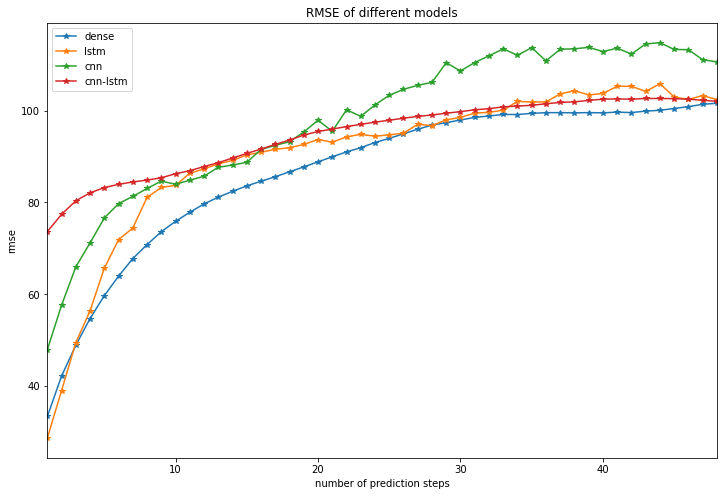

In [28]:
temp = pd.DataFrame(rmse)
index = [i for i in range(1, output_steps+1)]
temp.index = index

temp.plot(marker="*", title='RMSE of different models', figsize=(12,8))
plt.xlabel('number of prediction steps')
plt.ylabel('rmse')
plt.xlim([1,output_steps])

(1.0, 48.0)

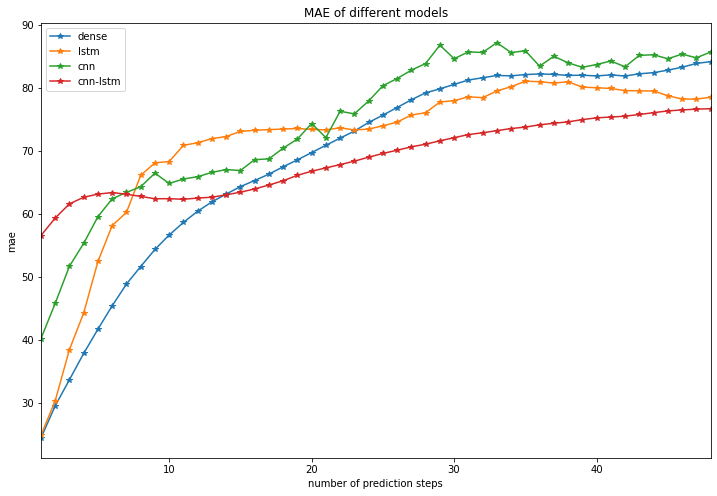

In [29]:
temp = pd.DataFrame(mae)
index = [i for i in range(1, output_steps+1)]
temp.index = index

temp.plot(marker="*", title='MAE of different models', figsize=(12,8))
plt.xlabel('number of prediction steps')
plt.ylabel('mae')
plt.xlim([1,output_steps])

# Summary

We compare the predictions using the different deep-learning models. They provide the predictions with a higher accuracy in a shorter term. The accuracy of predictions becomes lower in a longer term. 